# Shopping Recommendation System

In [3]:
import pandas as pd
import datetime as dt

df_original = pd.read_excel('market/Online Retail.xlsx')

In [4]:
df = df_original.copy(deep=True)

df['Revenue'] = df_original['Quantity'] * df_original['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df_original['InvoiceDate'])
# Filter out NaNs in CustomerID
df = df.dropna(subset=['CustomerID'])

df['CustomerID'] = df_original['CustomerID']

In [5]:
CURRENT_TIMESTAMP = df['InvoiceDate'].max() + dt.timedelta(days=1)

TIMEFRAME = 90 # days

df_filtered = df[df['InvoiceDate'] >= CURRENT_TIMESTAMP - dt.timedelta(days=TIMEFRAME)]

# rfm table
rfm_table = df_filtered.groupby('CustomerID').agg({
  'InvoiceDate': lambda x: (CURRENT_TIMESTAMP - x.max()).days,
  'InvoiceNo': 'nunique',
  'Revenue': lambda x: x.sum() * 30000
})

# Convert values
# recency = 5 if the customer made a purchase in the last 30 days, 4 if in the last 60 days, 3 if in the last 90 days, 2 if in the last 180 days, 1 if over 180 days
# frequency = 5 if the customer made more than 20 purchases, 4 if more than 10, 3 if more than 5, 2 if more than 2, 1 if less than 2
# monetary = 5 if the customer spent more than 20M, 4 if more than 10M, 3 if more than 5M, 2 if more than 2M, 1 if less than 2M
rfm_table['Recency'] = pd.cut(rfm_table['InvoiceDate'], bins=[0, 30, 60, 90, 180, 1000], labels=[5, 4, 3, 2, 1])
rfm_table['Frequency'] = pd.cut(rfm_table['InvoiceNo'], bins=[0, 2, 5, 10, 20, 1000], labels=[1, 2, 3, 4, 5])
rfm_table['Monetary'] = pd.cut(rfm_table['Revenue'], bins=[0, 2000000, 5000000, 10000000, 20000000, 1000000000], labels=[1, 2, 3, 4, 5])

# remove the original columns
rfm_table = rfm_table.drop(columns=['InvoiceDate', 'InvoiceNo', 'Revenue'])

rfm_table

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,5,1,5
12348.0,3,1,3
12349.0,5,1,5
12352.0,4,2,5
12356.0,5,1,1
...,...,...,...
18277.0,4,1,2
18278.0,3,1,3
18282.0,5,1,2


In [6]:
# Save to CSV
rfm_table.to_csv('rfm_table.csv')

## Analyze

In [7]:
# Load from CSV
rfm_table = pd.read_csv('rfm_table.csv', index_col='CustomerID')

In [8]:
def classify_customer(row):
  fm_score = (row['Frequency'] + row['Monetary']) // 2
  r_score = int(row['Recency'])
  if r_score <= 2 and fm_score <= 2:
    return 'Lost'
  if r_score == 3 and fm_score <= 2:
    return 'About to Sleep'
  if r_score == 4 and fm_score <= 1:
    return 'Promising'
  if r_score >= 5 and fm_score <= 1:
    return 'Price Sensitive'
  if r_score <= 2 and 2 < fm_score <= 4:
    return 'Hibernating'
  if r_score == 3 and fm_score == 3:
    return 'Need Attention'
  if r_score >= 4 and fm_score == 3:
    return 'Potential Loyalists'
  if r_score <= 2 and fm_score >= 5:
    return 'Can\'t Lose Them'
  if 3 <= r_score <= 4 and fm_score >= 4:
    return 'Loyal Customers'
  if r_score >= 5 and fm_score >= 4:
    return 'Champions'
  return 'Others'

rfm_table['CustomerType'] = rfm_table.apply(classify_customer, axis=1)

rfm_table

,Recency,Frequency,Monetary,CustomerType
CustomerID,,,,
12347.0,5,1,5.0,Potential Loyalists
12348.0,3,1,3.0,About to Sleep
12349.0,5,1,5.0,Potential Loyalists
12352.0,4,2,5.0,Potential Loyalists
12356.0,5,1,1.0,Price Sensitive
...,...,...,...,...
18277.0,4,1,2.0,Promising
18278.0,3,1,3.0,About to Sleep
18282.0,5,1,2.0,Price Sensitive


In [9]:
# filter where others
rfm_table[rfm_table['CustomerType'] == 'Others']

,Recency,Frequency,Monetary,CustomerType
CustomerID,,,,
12367.0,5,1,3.0,Others
12375.0,5,1,3.0,Others
12384.0,5,1,3.0,Others
12391.0,5,1,4.0,Others
12403.0,4,1,4.0,Others
...,...,...,...,...
18252.0,4,1,4.0,Others
18263.0,5,1,4.0,Others
18270.0,4,1,3.0,Others


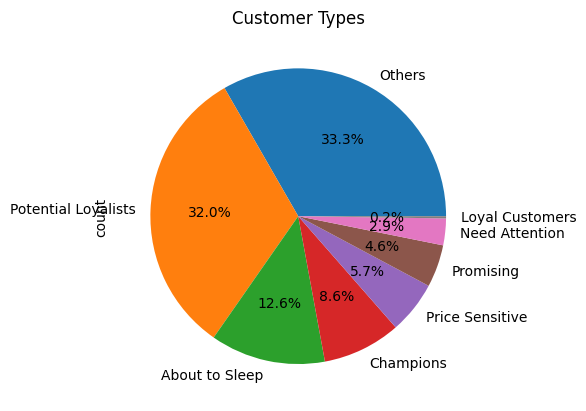

In [10]:
# Draw a pie chart of customer types
import matplotlib.pyplot as plt

customer_type_counts = rfm_table['CustomerType'].value_counts()
customer_type_counts.plot.pie(autopct='%1.1f%%')
plt.title('Customer Types')
plt.show()